**Import Libraries**

This sheet contains code used in analysis, extract, feature selection and transform X-Ray image set in preperation for training and validation. The Chexpert data set contains X-Ray images for 14 different classes. We are going to build an image classifier to predict presence of Pnuemonia in a given X-Ray image.

In [507]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from IPython.display import Image, display
pd.set_option('display.max_colwidth', 100)

**Read training image meta data into Pandas Dataframe**

In [508]:
working_path = os.getcwd()
data = pd.read_csv(working_path + '/data/train.csv')

In [509]:
print("Training data shape: " + str(data.shape))

Training data shape: (223414, 19)


In [510]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223414 entries, 0 to 223413
Data columns (total 19 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Path                        223414 non-null  object 
 1   Sex                         223414 non-null  object 
 2   Age                         223414 non-null  int64  
 3   Frontal/Lateral             223414 non-null  object 
 4   AP/PA                       191027 non-null  object 
 5   No Finding                  22381 non-null   float64
 6   Enlarged Cardiomediastinum  44839 non-null   float64
 7   Cardiomegaly                46203 non-null   float64
 8   Lung Opacity                117778 non-null  float64
 9   Lung Lesion                 11944 non-null   float64
 10  Edema                       85956 non-null   float64
 11  Consolidation               70622 non-null   float64
 12  Pneumonia                   27608 non-null   float64
 13  Atelectasis   

In [511]:
data.rename(columns={'Frontal/Lateral': 'Frontal_Lateral', 'AP/PA': 'AP_PA'}, inplace=True)

__Extract patient id, study number, and filename for future use__

In [512]:
data_path = pd.DataFrame.from_records(train_df.Path.apply(lambda r: r.split('/')), columns=['set_name', 'set_type', 'patient_id', 'study_no', 'file_name'])

In [513]:
data_path.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223414 entries, 0 to 223413
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   set_name    223414 non-null  object
 1   set_type    223414 non-null  object
 2   patient_id  223414 non-null  object
 3   study_no    223414 non-null  object
 4   file_name   223414 non-null  object
dtypes: object(5)
memory usage: 8.5+ MB


**Merge original metadate frames with new columns with data extracted from file path**

In [514]:
data = pd.merge(data, data_path, left_index=True, right_index=True)

In [515]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223414 entries, 0 to 223413
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Path                        223414 non-null  object 
 1   Sex                         223414 non-null  object 
 2   Age                         223414 non-null  int64  
 3   Frontal_Lateral             223414 non-null  object 
 4   AP_PA                       191027 non-null  object 
 5   No Finding                  22381 non-null   float64
 6   Enlarged Cardiomediastinum  44839 non-null   float64
 7   Cardiomegaly                46203 non-null   float64
 8   Lung Opacity                117778 non-null  float64
 9   Lung Lesion                 11944 non-null   float64
 10  Edema                       85956 non-null   float64
 11  Consolidation               70622 non-null   float64
 12  Pneumonia                   27608 non-null   float64
 13  Atelectasis   

**Compute and Display Counts of Different Classes in X-Ray Training Images**

In [516]:
data.apply(pd.Series.value_counts).iloc[0:3,5:18]

,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture
-1.0,NaN,12403.0,8087.0,5598.0,1488.0,12984.0,27742.0,18770.0,33739.0,3145.0,11628.0,2653.0,642.0
0,NaN,21638.0,11116.0,6599.0,1270.0,20726.0,28097.0,2799.0,1328.0,56341.0,35396.0,316.0,2512.0
1.0,22381.0,10798.0,27000.0,105581.0,9186.0,52246.0,14783.0,6039.0,33376.0,19448.0,86187.0,3523.0,9040.0


**Compute and Display Counts of Different Classes in X-Ray Test Images**

**Drop unused class labels**

**Remove lateral X-Ray images which are insignificant and spare**

In [517]:
data.groupby(['No Finding']).sum()

,Age,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
No Finding,,,,,,,,,,,,,,
1.0,1139827,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8698.0


In [518]:
data.groupby(['Pneumonia']).sum()

,Age,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
Pneumonia,,,,,,,,,,,,,,
-1.0,1185042,0.0,-265.0,1298.0,14841.0,753.0,-908.0,1460.0,-4622.0,641.0,6147.0,86.0,469.0,7601.0
0.0,167198,1158.0,-8.0,138.0,535.0,113.0,103.0,-2.0,71.0,20.0,189.0,18.0,98.0,566.0
1.0,373337,0.0,-146.0,351.0,3793.0,390.0,729.0,469.0,-168.0,115.0,1462.0,55.0,136.0,1752.0


In [519]:
data_no_finding = data[data['No Finding']==1.0].copy().reset_index(drop=True)

In [520]:
data_no_finding.apply(pd.Series.value_counts).iloc[0:3,5:18]

,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture
-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,8394.0,3350.0,2421.0,377.0,4461.0,8836.0,1158.0,483.0,13411.0,11450.0,20.0,1091.0
1.0,22381.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [521]:
drop_class_labels = ['Pneumonia', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 
                      'Lung Lesion', 'Edema','Consolidation', 'Atelectasis', 'Pneumothorax', 
                      'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
data_no_finding.drop(drop_class_labels, inplace=True, axis=1)

In [522]:
data_no_finding = data_no_finding.dropna()

In [523]:
data_no_finding.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16974 entries, 0 to 22380
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Path             16974 non-null  object 
 1   Sex              16974 non-null  object 
 2   Age              16974 non-null  int64  
 3   Frontal_Lateral  16974 non-null  object 
 4   AP_PA            16974 non-null  object 
 5   No Finding       16974 non-null  float64
 6   set_name         16974 non-null  object 
 7   set_type         16974 non-null  object 
 8   patient_id       16974 non-null  object 
 9   study_no         16974 non-null  object 
 10  file_name        16974 non-null  object 
dtypes: float64(1), int64(1), object(9)
memory usage: 1.6+ MB


In [524]:
data_no_finding['No Finding']=0

In [525]:
data_no_finding.columns=['Path', 'Sex', 'Age', 'Frontal_Lateral', 'AP_PA', 'Class',
       'set_name', 'set_type', 'patient_id', 'study_no', 'file_name']

In [526]:
data_no_finding.head()

,Path,Sex,Age,Frontal_Lateral,AP_PA,Class,set_name,set_type,patient_id,study_no,file_name
0,CheXpert-v1.0-small/train/patient00001/study1/view1_frontal.jpg,Female,68,Frontal,AP,0,CheXpert-v1.0-small,train,patient00001,study1,view1_frontal.jpg
1,CheXpert-v1.0-small/train/patient00004/study1/view1_frontal.jpg,Female,20,Frontal,PA,0,CheXpert-v1.0-small,train,patient00004,study1,view1_frontal.jpg
3,CheXpert-v1.0-small/train/patient00005/study1/view1_frontal.jpg,Male,33,Frontal,PA,0,CheXpert-v1.0-small,train,patient00005,study1,view1_frontal.jpg
5,CheXpert-v1.0-small/train/patient00006/study1/view1_frontal.jpg,Female,42,Frontal,AP,0,CheXpert-v1.0-small,train,patient00006,study1,view1_frontal.jpg
6,CheXpert-v1.0-small/train/patient00010/study1/view1_frontal.jpg,Female,50,Frontal,PA,0,CheXpert-v1.0-small,train,patient00010,study1,view1_frontal.jpg


In [527]:
data_pneumonia = data[data['Pneumonia']==1.0].copy().reset_index(drop=True)
#data_pneumonia = data[(data['Pneumonia']==1.0) & 
#                      (data['Enlarged Cardiomediastinum']!=1.0) &
#                      (data['Cardiomegaly']!=1.0) &
#                     (data['Lung Opacity']!=1.0) &
#                      (data['Lung Lesion']!=1.0) &
#                      (data['Edema']!=1.0) &
#                      (data['Consolidation']!=1.0) &
#                      (data['Atelectasis']!=1.0) &
#                      (data['Pneumothorax']!=1.0) &    
#                      (data['Pleural Effusion']!=1.0) &
#                      (data['Pleural Other']!=1.0) &    
#                      (data['Fracture']!=1.0)]

In [528]:
data_pneumonia.apply(pd.Series.value_counts).iloc[0:3,5:18]

,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture
-1.0,NaN,296.0,144.0,232.0,64.0,475.0,545.0,NaN,783.0,31.0,271.0,68.0,5.0
0.0,NaN,439.0,172.0,129.0,42.0,294.0,528.0,NaN,17.0,571.0,522.0,27.0,23.0
1.0,NaN,150.0,495.0,4025.0,454.0,1204.0,1014.0,6039.0,615.0,146.0,1733.0,123.0,141.0


In [529]:
data_pneumonia['Pneumonia'].value_counts()

1.0    6039
Name: Pneumonia, dtype: int64

In [530]:
drop_class_labels = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 
                      'Lung Lesion', 'Edema','Consolidation', 'Atelectasis', 'Pneumothorax', 
                      'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
data_pneumonia.drop(drop_class_labels, inplace=True, axis=1)

In [531]:
data_pneumonia.columns=['Path', 'Sex', 'Age', 'Frontal_Lateral', 'AP_PA', 'Class',
       'set_name', 'set_type', 'patient_id', 'study_no', 'file_name']

In [532]:
data_pneumonia.head()

,Path,Sex,Age,Frontal_Lateral,AP_PA,Class,set_name,set_type,patient_id,study_no,file_name
0,CheXpert-v1.0-small/train/patient00085/study1/view1_frontal.jpg,Male,88,Frontal,AP,1.0,CheXpert-v1.0-small,train,patient00085,study1,view1_frontal.jpg
1,CheXpert-v1.0-small/train/patient00086/study1/view1_frontal.jpg,Female,77,Frontal,AP,1.0,CheXpert-v1.0-small,train,patient00086,study1,view1_frontal.jpg
2,CheXpert-v1.0-small/train/patient00112/study1/view1_frontal.jpg,Male,35,Frontal,PA,1.0,CheXpert-v1.0-small,train,patient00112,study1,view1_frontal.jpg
3,CheXpert-v1.0-small/train/patient00112/study1/view2_lateral.jpg,Male,35,Lateral,NaN,1.0,CheXpert-v1.0-small,train,patient00112,study1,view2_lateral.jpg
4,CheXpert-v1.0-small/train/patient00114/study15/view1_frontal.jpg,Male,55,Frontal,AP,1.0,CheXpert-v1.0-small,train,patient00114,study15,view1_frontal.jpg


In [533]:
data_pneumonia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6039 entries, 0 to 6038
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Path             6039 non-null   object 
 1   Sex              6039 non-null   object 
 2   Age              6039 non-null   int64  
 3   Frontal_Lateral  6039 non-null   object 
 4   AP_PA            4675 non-null   object 
 5   Class            6039 non-null   float64
 6   set_name         6039 non-null   object 
 7   set_type         6039 non-null   object 
 8   patient_id       6039 non-null   object 
 9   study_no         6039 non-null   object 
 10  file_name        6039 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 519.1+ KB


In [534]:
data_pneumonia[['Frontal_Lateral', 'AP_PA']].apply(pd.Series.value_counts).iloc[:,:]

,Frontal_Lateral,AP_PA
AP,NaN,3476.0
Frontal,4675.0,NaN
LL,NaN,1.0
Lateral,1364.0,NaN
PA,NaN,1198.0


In [535]:
data_pneumonia_idx=data_pneumonia[data_pneumonia['Frontal_Lateral']=='Lateral'].index
data_no_finding_idx=data_no_finding [data_no_finding['Frontal_Lateral']=='Lateral'].index

In [536]:
data_pneumonia.drop(data_pneumonia_idx, inplace=True)
data_no_finding.drop(data_no_finding_idx, inplace=True)

In [537]:
data_pneumonia.head()

,Path,Sex,Age,Frontal_Lateral,AP_PA,Class,set_name,set_type,patient_id,study_no,file_name
0,CheXpert-v1.0-small/train/patient00085/study1/view1_frontal.jpg,Male,88,Frontal,AP,1.0,CheXpert-v1.0-small,train,patient00085,study1,view1_frontal.jpg
1,CheXpert-v1.0-small/train/patient00086/study1/view1_frontal.jpg,Female,77,Frontal,AP,1.0,CheXpert-v1.0-small,train,patient00086,study1,view1_frontal.jpg
2,CheXpert-v1.0-small/train/patient00112/study1/view1_frontal.jpg,Male,35,Frontal,PA,1.0,CheXpert-v1.0-small,train,patient00112,study1,view1_frontal.jpg
4,CheXpert-v1.0-small/train/patient00114/study15/view1_frontal.jpg,Male,55,Frontal,AP,1.0,CheXpert-v1.0-small,train,patient00114,study15,view1_frontal.jpg
5,CheXpert-v1.0-small/train/patient00122/study5/view1_frontal.jpg,Female,72,Frontal,AP,1.0,CheXpert-v1.0-small,train,patient00122,study5,view1_frontal.jpg


In [538]:
data_no_finding.reset_index(drop=True, inplace=True)
data_pneumonia.reset_index(drop=True, inplace=True)

In [539]:
data_no_finding_idx = data_no_finding[data_no_finding['AP_PA']=="PA"].index
data_pneumonia_idx = data_pneumonia[data_pneumonia['AP_PA']=="PA"].index

In [540]:
data_no_finding.drop(data_no_finding_idx , inplace=True)
data_pneumonia.drop(data_pneumonia_idx, inplace=True)

In [541]:
data_no_finding.drop(['AP_PA', 'set_name'], axis=1, inplace=True)
data_pneumonia.drop(['AP_PA', 'set_name'], axis=1, inplace=True)

In [542]:
data_no_finding.dropna(inplace=True)
data_pneumonia.dropna(inplace=True)

In [543]:
data_no_finding.reset_index(drop=True, inplace=True)
data_pneumonia.reset_index(drop=True, inplace=True)

In [544]:
data_pneumonia.info()
data_no_finding.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3477 entries, 0 to 3476
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Path             3477 non-null   object 
 1   Sex              3477 non-null   object 
 2   Age              3477 non-null   int64  
 3   Frontal_Lateral  3477 non-null   object 
 4   Class            3477 non-null   float64
 5   set_type         3477 non-null   object 
 6   patient_id       3477 non-null   object 
 7   study_no         3477 non-null   object 
 8   file_name        3477 non-null   object 
dtypes: float64(1), int64(1), object(7)
memory usage: 244.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11475 entries, 0 to 11474
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Path             11475 non-null  object
 1   Sex              11475 non-null  object
 2   Age              11475 non-null

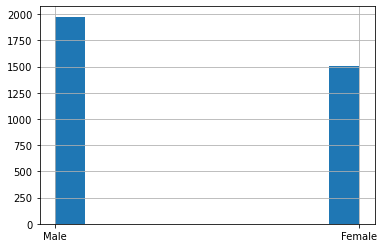

In [545]:
data_pneumonia.Sex.hist()

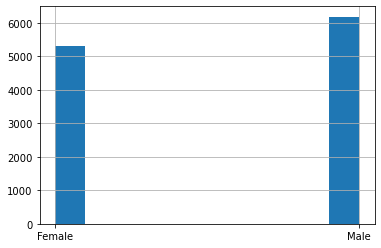

In [546]:
data_no_finding.Sex.hist()

**Class counts in Pneumonia dataset**

In [547]:
data_pneumonia.drop(['Sex'], axis=1, inplace=True)
data_no_finding.drop(['Sex'], axis=1, inplace=True)

In [548]:
data_pneumonia.head()

,Path,Age,Frontal_Lateral,Class,set_type,patient_id,study_no,file_name
0,CheXpert-v1.0-small/train/patient00085/study1/view1_frontal.jpg,88,Frontal,1.0,train,patient00085,study1,view1_frontal.jpg
1,CheXpert-v1.0-small/train/patient00086/study1/view1_frontal.jpg,77,Frontal,1.0,train,patient00086,study1,view1_frontal.jpg
2,CheXpert-v1.0-small/train/patient00114/study15/view1_frontal.jpg,55,Frontal,1.0,train,patient00114,study15,view1_frontal.jpg
3,CheXpert-v1.0-small/train/patient00122/study5/view1_frontal.jpg,72,Frontal,1.0,train,patient00122,study5,view1_frontal.jpg
4,CheXpert-v1.0-small/train/patient00155/study6/view1_frontal.jpg,70,Frontal,1.0,train,patient00155,study6,view1_frontal.jpg


In [549]:
data_no_finding.head()

,Path,Age,Frontal_Lateral,Class,set_type,patient_id,study_no,file_name
0,CheXpert-v1.0-small/train/patient00001/study1/view1_frontal.jpg,68,Frontal,0,train,patient00001,study1,view1_frontal.jpg
1,CheXpert-v1.0-small/train/patient00006/study1/view1_frontal.jpg,42,Frontal,0,train,patient00006,study1,view1_frontal.jpg
2,CheXpert-v1.0-small/train/patient00017/study1/view1_frontal.jpg,56,Frontal,0,train,patient00017,study1,view1_frontal.jpg
3,CheXpert-v1.0-small/train/patient00030/study1/view1_frontal.jpg,74,Frontal,0,train,patient00030,study1,view1_frontal.jpg
4,CheXpert-v1.0-small/train/patient00049/study1/view1_frontal.jpg,63,Frontal,0,train,patient00049,study1,view1_frontal.jpg


__For Training Data Split dataset into two frames for each label class__

In [550]:
def copy_n_images(dataframe, new_path, set_name, n_start, no_rec):
    #This function will extract a set of images from the entire CheXpert downloaded set
    #Then will copy images and create directory structures from main set in datafram
    #dataframe: chexpert meta data dataframe (e.g. train.csv dataframe)
    #new_path: directory structure where to move images to. (e.g. 'data')
    #set_name: type of batch (train, valid, test) 
    #n_start: index starting value in dataframe
    #no_rec: inumber of images to copy in this batch
    
    from shutil import copyfile
    from sys import exit
    print("\nSet Name: " + set_name + "\n Start Index: " + str(n_start) + "\n No of Records: " + str(no_rec))
    n=no_rec

    if not os.path.exists(working_path + '/' + new_path): 
        os.mkdir(working_path + '/' + new_path)
        
    if not os.path.exists(working_path + '/' + new_path + '/' + set_name): 
        os.mkdir(working_path + '/' + new_path+  '/' + set_name)
        
    for i in range(n_start, n_start + no_rec ,1):

        source = "/home/sphinx/Documents/capstone/data/CheXpert/" + dataframe.Path.iloc[i]
        path = working_path + '/' + new_path+ '/' + set_name +'/' + dataframe.patient_id.iloc[i] + '/'

        if not os.path.exists(path): 
            os.mkdir(path)

        path = path + dataframe.study_no.iloc[i]+'/'

        if not os.path.exists(path): 
            os.mkdir(path)

        target = path+dataframe.file_name.iloc[i]

        # adding exception handling
        try:
            copyfile(source, target)
        except IOError as e:
            print("Unable to copy file. %s" % e)
            exit(1)
        except:
            print("Unexpected error:", sys.exc_info())
            exit(1)


In [551]:
data_no_finding.shape, data_pneumonia.shape

((11475, 8), (3477, 8))

**Create three batchs with specified image counts with equal number of classifications 
and create new dataframe with new path information**

In [552]:
test_set_count = 160

set_type_count_pos = [test_set_count, data_pneumonia.shape[0]-test_set_count]
set_type_count_neg = [test_set_count, data_pneumonia.shape[0]-test_set_count]

#set_type_count = [test_set_count]

set_type = ['test', 'train']
start = 0
dataset= pd.DataFrame()
for k, v in enumerate(set_type):
    temp_df = pd.DataFrame()
    copy_n_images(data_pneumonia, 'data', v, start, set_type_count_pos[k])
    copy_n_images(data_no_finding, 'data', v, start, set_type_count_neg[k])
    temp_df=temp_df.append(data_pneumonia.iloc[start:start+set_type_count_pos[k]],ignore_index=True)
    temp_df=temp_df.append(data_no_finding.iloc[start:start+set_type_count_neg[k]],ignore_index=True) 
    temp_df['set_type'] = v
    temp_df.Path = temp_df.apply(lambda x: 'data/' + v + '/' + str(x[5])+ '/' + str(x[6])+ '/' + str(x[7]), axis=1) 
    dataset = dataset.append(temp_df)
    start += test_set_count




Set Name: test
 Start Index: 0
 No of Records: 160

Set Name: test
 Start Index: 0
 No of Records: 160

Set Name: train
 Start Index: 160
 No of Records: 3317

Set Name: train
 Start Index: 160
 No of Records: 3317


In [553]:
dataset.reset_index(drop=True, inplace=True)

In [554]:
dataset['Class'].value_counts()

0.0    3477
1.0    3477
Name: Class, dtype: int64

In [555]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6954 entries, 0 to 6953
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Path             6954 non-null   object 
 1   Age              6954 non-null   int64  
 2   Frontal_Lateral  6954 non-null   object 
 3   Class            6954 non-null   float64
 4   set_type         6954 non-null   object 
 5   patient_id       6954 non-null   object 
 6   study_no         6954 non-null   object 
 7   file_name        6954 non-null   object 
dtypes: float64(1), int64(1), object(6)
memory usage: 434.8+ KB


In [556]:
dataset.head(5)

,Path,Age,Frontal_Lateral,Class,set_type,patient_id,study_no,file_name
0,data/test/patient00085/study1/view1_frontal.jpg,88,Frontal,1.0,test,patient00085,study1,view1_frontal.jpg
1,data/test/patient00086/study1/view1_frontal.jpg,77,Frontal,1.0,test,patient00086,study1,view1_frontal.jpg
2,data/test/patient00114/study15/view1_frontal.jpg,55,Frontal,1.0,test,patient00114,study15,view1_frontal.jpg
3,data/test/patient00122/study5/view1_frontal.jpg,72,Frontal,1.0,test,patient00122,study5,view1_frontal.jpg
4,data/test/patient00155/study6/view1_frontal.jpg,70,Frontal,1.0,test,patient00155,study6,view1_frontal.jpg


In [557]:
dataset.tail(5)

,Path,Age,Frontal_Lateral,Class,set_type,patient_id,study_no,file_name
6949,data/train/patient20704/study1/view1_frontal.jpg,43,Frontal,0.0,train,patient20704,study1,view1_frontal.jpg
6950,data/train/patient20704/study1/view2_frontal.jpg,43,Frontal,0.0,train,patient20704,study1,view2_frontal.jpg
6951,data/train/patient20710/study1/view1_frontal.jpg,27,Frontal,0.0,train,patient20710,study1,view1_frontal.jpg
6952,data/train/patient20728/study1/view1_frontal.jpg,36,Frontal,0.0,train,patient20728,study1,view1_frontal.jpg
6953,data/train/patient20728/study2/view1_frontal.jpg,36,Frontal,0.0,train,patient20728,study2,view1_frontal.jpg


__After creating all files, export dataframe matching image set__

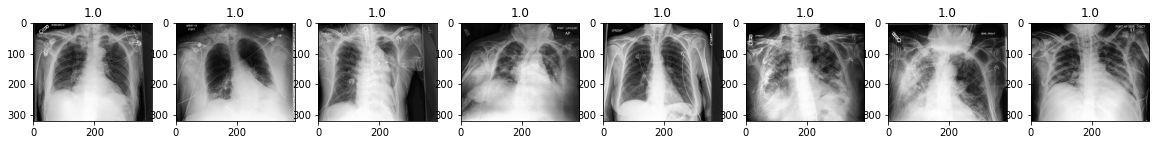

In [558]:
fig, ax = plt.subplots(1, 8, figsize=(20,10))
for k, v in enumerate (ax):
        v.imshow(cv2.imread(working_path + "/" + dataset.Path[k]))
        v.set_title(dataset.Class[k])

In [559]:
dataset.to_csv(working_path + '/data/pneumonia.csv', index=False)